# Uncertainty and sensitivity

## Monte Carlo uncertainty analysis

### Model objects

BioSTEAM streamlines uncertainty analysis with an object-oriented framework where a [Model](../API/evaluation/Model.txt) object samples from parameter distributions and reevaluates biorefinery metrics at each new condition. In essence, a Model object sets parameter values, simulates the biorefinery system, and evaluates metrics across an array of samples.

Model objects are able to cut down simulation time by sorting the samples to minimize perturbations to the system between simulations. This decreases the number of iterations required to solve recycle systems. The following examples show how Model objects can be used.


### Create parameter distributions

**Let's first learn how to create common parameter distributions using** [chaospy](https://chaospy.readthedocs.io/en/master/user_guide/quick_tutorial.html).

A triangular distribution is typically used when the parameter is uncertain within given limits, but is heuristically known to take a particular value. Create a triangular distribution:

In [1]:
from warnings import filterwarnings; filterwarnings('ignore') 
from chaospy import distributions as shape
lower_bound = 0
most_probable = 0.5
upper_bound = 1
triang = shape.Triangle(lower_bound, most_probable, upper_bound)
print(triang)

Triangle(0, 0.5, 1)


A uniform distribution is used when the theoretical limits of the parameter is known, but no information is available to discern which values are more probable. Create a uniform distribution:

In [2]:
from chaospy import distributions as shape
lower_bound = 0
upper_bound = 1
unif = shape.Uniform(lower_bound, upper_bound)
print(unif)

Uniform()


A large set of distributions are available through chaospy, but generally triangular and uniform distributions are the most widely used to describe the uncertainty of parameters in Monte Carlo analyses.

### Parameter objects

**Parameter objects are simply structures BioSTEAM uses to manage parameter values and distributions.**

This section is just to get you familiar with Parameter objects. All the fields that a Parameter object can have are described below. Don't worry if you don't fully understand what each field does. The main idea is that we need to define the `setter` function that the Parameter object uses to set the parameter value to the `element` (e.g. unit operation, stream, etc.) it pertains to. We can also pass a `distribution` (i.e. a chaospy distribution) that will be accessible for Model objects to sample from. As for the `name`, `units` of measure, and the `baseline` value, these are all for bookkeeping purposes. BioSTEAM incorporates the `name` and `units` of measure when creating a DataFrame of Monte Carlo results and parameter distributions. Parameter objects are created by Model objects which implicitly pass both the `system` affected by the parameter, and the `simulate` function. But don't worry about these last two fields, they are automatically added by the Model object when creating the parameter.

**simulate:** [function] Should simulate parameter effects.

**system:** [System] System associated to parameter.

**name:** [str] Name of parameter.

**units:** [str] Units of measure.

**baseline:** [float] Baseline value of parameter.

**element:** [object] Element associated to parameter.

**setter:** [function] Should set the parameter.

**distribution:** [chaospy.Dist] Parameter distribution.

Hopefully things will be become clearer as we start to create the parameter objects in the following sections...
    

### Create a model object

**Model objects are used to evaluate metrics around multiple parameters of a system.**

Create a Model object of the sugarcane biorefinery with internal rate of return and utility cost as metrics:

In [3]:
from biorefineries import sugarcane as sc
import biosteam as bst
sc.load()
solve_IRR = sc.tea.solve_IRR
total_utility_cost = lambda: sc.tea.utility_cost / 10**6 # In 10^6 USD/yr
metrics = (bst.Metric('Internal rate of return', sc.tea.solve_IRR, '%'),
           bst.Metric('Utility cost', total_utility_cost, '10^6 USD/yr'))
model = bst.Model(sc.sys, metrics)


The Model object begins with no parameters: 

In [4]:
model

Model:
(No parameters)
metrics: Internal rate of return [%]
         Utility cost [10^6 USD/yr]


### Add cost parameters

**A cost parameter changes cost requirements but not affect mass and energy balances.**

Add number of fermentation reactors as a "cost" parameter:

In [5]:
R301 = bst.main_flowsheet.unit.R301 # The Fermentation Unit
@model.parameter(
    name='Number of reactors',
    element=R301, kind='cost',
    distribution=shape.Uniform(4, 10),
    hook=lambda N: int(round(N)) # Make sure value is an integer
)
def set_N_reactors(N):
    R301.N = N

The decorator uses the function to create a Parameter object and add it to the model:

In [6]:
parameters = model.get_parameters()
parameters

(<Parameter: [Fermentation-R301] Number of reactors>,)

Calling a Parameter object will update the parameter and results:

In [7]:
set_N_reactors_parameter = parameters[0]
set_N_reactors_parameter(5)
print(f'Puchase cost at 5 reactors: ${R301.purchase_cost:,.0f}')
set_N_reactors_parameter(8)
print(f'Puchase cost at 8 reactors: ${R301.purchase_cost:,.0f}')

Puchase cost at 5 reactors: $2,623,357
Puchase cost at 8 reactors: $3,137,039


Add the fermentation unit base cost as a "cost" parameter with a triangular distribution:

In [8]:
reactors_cost_coefficients = R301.cost_items['Reactors']
mid = reactors_cost_coefficients.n # Most probable at baseline value
lb = mid - 0.1 # Minimum
ub = mid + 0.1 # Maximum
@model.parameter(element=R301, kind='cost',
                 distribution=shape.Triangle(lb, mid, ub))
def set_exponential_cost_coefficient(exponential_cost_coefficient):
    reactors_cost_coefficients.n = exponential_cost_coefficient

Note that if the name was not defined, it defaults to the setter's signature:

In [9]:
model.get_parameters()

(<Parameter: [Fermentation-R301] Number of reactors>,
 <Parameter: [Fermentation-R301] Exponential cost coefficient>)

### Add isolated parameters

**An isolated parameter does not affect Unit objects in any way.**

Add feedstock price as a "isolated" parameter:

In [10]:
feedstock = sc.sugarcane # The feedstock stream
lb = feedstock.price * 0.9 # Minimum price
ub = feedstock.price * 1.1 # Maximum price
@model.parameter(element=feedstock, kind='isolated', units='USD/kg',
                 distribution=shape.Uniform(lb, ub))
def set_feed_price(feedstock_price):
    feedstock.price = feedstock_price

### Add coupled parameters

**A coupled parameter affects mass and energy balances of the system.**

Add fermentation efficiency as a "coupled" parameter:

In [11]:
@model.parameter(element=R301, kind='coupled',
                 distribution=shape.Triangle(0.85, 0.90, 0.95))
def set_fermentation_efficiency(efficiency):
    R301.efficiency = efficiency

Add crushing capacity as a "coupled" parameter:

In [12]:
lb = feedstock.F_mass * 0.9 
ub = feedstock.F_mass * 1.1
@model.parameter(element=feedstock, kind='coupled',
                 distribution=shape.Uniform(lb, ub))
def set_crushing_capacity(capacity):
    feedstock.F_mass = capacity

### Evaluate metric given a sample

**The model can be called to evaluate a sample of parameters.**

Note that all parameters are stored in the model in the same order they were added:

In [13]:
model

Model:
parameters: Fermentation-R301 - Number of reactors
            Fermentation-R301 - Exponential cost coefficient
            Stream-Sugarcane - Feedstock price [USD/kg]
            Fermentation-R301 - Efficiency
            Stream-Sugarcane - Capacity
metrics: Internal rate of return [%]
         Utility cost [10^6 USD/yr]


Get dictionary that contain DataFrame objects of parameter distributions:

In [14]:
df_dct = model.get_distribution_summary()
df_dct['Uniform']

,Element,Name,Units,Shape,lower,upper
0,Fermentation-R301,Number of reactors,,Uniform,4,10
1,Stream-Sugarcane,Feedstock price,USD/kg,Uniform,0.0311,0.038
2,Stream-Sugarcane,Capacity,,Uniform,3e+05,3.67e+05


In [15]:
df_dct['Triangle']

,Element,Name,Units,Shape,lower,midpoint,upper
0,Fermentation-R301,Exponential cost coefficient,,Triangle,0.4,0.5,0.6
1,Fermentation-R301,Efficiency,,Triangle,0.85,0.9,0.95


Evaluate sample:

In [16]:
model([8, 100000, 0.040, 0.85, feedstock.F_mass]) # Returns metrics (IRR and utility cost)

-  Internal rate of return [%]   0.0873
   Utility cost [10^6 USD/yr]     -18.2
dtype: float64

### Monte Carlo

Sample from a joint distribution, and simulate samples:

In [17]:
import numpy as np
N_samples = 500
rule = 'L' # For Latin-Hypercube sampling
np.random.seed(1234) # For consistent results
samples = model.sample(N_samples, rule)
model.load_samples(samples)
model.evaluate(
    notify=100 # Also print elapsed time after 50 simulations
) 

[100] Elapsed time: 20 sec
[200] Elapsed time: 41 sec
[300] Elapsed time: 62 sec
[400] Elapsed time: 83 sec
[500] Elapsed time: 104 sec


Although the system uses the last solution as an initial guess for the next, each scenario may be vastly different and there is no guarantee that this initial guess would be any better. Luckily, BioSTEAM can minimize perturbations to the system between simulations by pre-sorting the scenarios:

In [18]:
model.load_samples(
    samples,
    optimize=True, # Optimize simulation order
)
model.evaluate(
    notify=100 # Also print elapsed time after 100 simulations
) 

[100] Elapsed time: 18 sec
[200] Elapsed time: 37 sec
[300] Elapsed time: 54 sec
[400] Elapsed time: 72 sec
[500] Elapsed time: 91 sec


BioSTEAM can also use convergence data from past simulations to make better starting guesses for accelerated recycle convergence:

In [19]:
model.load_samples(
    samples,
    optimize=True
)
model.evaluate(
    notify=100, # Also print elapsed time after 100 simulations
    predict_convergence=True,
) 

[100] Elapsed time: 19 sec
[200] Elapsed time: 37 sec
[300] Elapsed time: 54 sec
[400] Elapsed time: 72 sec
[500] Elapsed time: 90 sec


Notice how it took less time (~%10 less) to run the Monte Carlo simulations after optimizing the simulation order and/or predicting recycle loop convergence.

All data from simulation is stored in `<Model>.table`:

In [20]:
model.table # All evaluations are stored as a pandas DataFrame

Element  Fermentation-R301                                      Stream-Sugarcane Fermentation-R301 Stream-Sugarcane                           -  \
Feature Number of reactors Exponential cost coefficient Feedstock price [USD/kg]        Efficiency         Capacity Internal rate of return [%]   
0                        5                        0.491                   0.0326             0.912         3.45e+05                       0.156   
1                        7                        0.508                   0.0356             0.934         3.44e+05                       0.144   
2                        4                        0.513                   0.0328             0.888         3.59e+05                        0.15   
3                        5                        0.435                   0.0362             0.904         3.33e+05                       0.128   
4                        5                        0.519                    0.036               0.9         3.16e+05                       0.125   
..                     ...                          ...                      ...               ...              ...                         ...   
495                      8                        0.562                   0.0315             0.916         3.15e+05                       0.154   
496                      7                        0.587                   0.0327             0.899         3.45e+05                        0.15   
497                      9                        0.507                   0.0352             0.931         3.25e+05                        0.14   
498                      7                        0.531                   0.0362             0.897         3.54e+05                       0.131   
499                      4                        0.504                   0.0358             0.932         3.07e+05                       0.135   

Element                             
Feature Utility cost [10^6 USD/yr]  
0                            -18.5  
1                            -18.3  
2                            -19.4  
3                            -17.9  
4                              -17  
..                             ...  
495                          -16.9  
496                          -18.6  
497                          -17.3  
498                          -19.1  
499                          -16.4  

[500 rows x 7 columns]

## Sensitivity with Spearman's rank order correlation

Model objects also presents methods for sensitivity analysis such as Spearman's correlation, a measure of monotonicity between variables:

In [21]:
df_rho, df_p = model.spearman_r()
print(df_rho['-', 'Internal rate of return [%]'])

Element            Parameter                   
Fermentation-R301  Number of reactors             -0.0245
                   Exponential cost coefficient    0.0696
Stream-Sugarcane   Feedstock price [USD/kg]        -0.818
Fermentation-R301  Efficiency                       0.426
Stream-Sugarcane   Capacity                         0.261
Name: (-, Internal rate of return [%]), dtype: float64


Create a tornado plot of Spearman's correlation between all parameters and IRR:

(<Figure size 640x480 with 3 Axes>,
 <Axes: xlabel="Spearman's correlation with IRR [%]">)

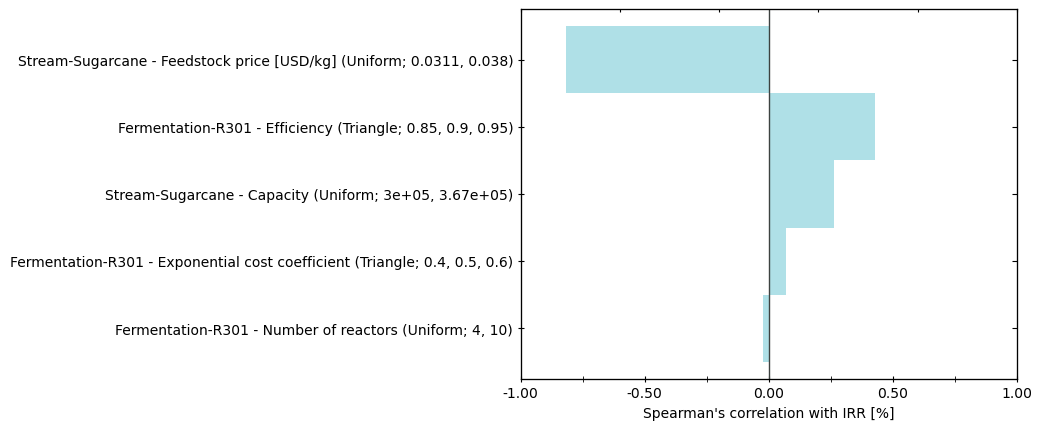

In [22]:
bst.plots.plot_spearman_1d(df_rho['-', 'Internal rate of return [%]'], 
                           index=[i.describe() for i in model.parameters],
                           name='IRR [%]')

## Single point sensitivity

A quick way to evaluate sentivity is through single point sensitivity analysis, whereby a metric is evaluated at the baseline and at the lower and upper limits of each parameter. This method ignores the interactions between parameters and their distributions, but can help screen whether a system is sensitive to a given parameter. Model objects also facilitate this analysis:

In [26]:
model.recycle_model = None
baseline, lower, upper = model.single_point_sensitivity()
print('BASELINE')
print('--------')
print(baseline)
print()
print('LOWER')
print('-----')
print(lower)
print()
print('UPPER')
print('-----')
print(upper)

BASELINE
--------
Element  Feature                    
-        Internal rate of return [%]   0.136
         Utility cost [10^6 USD/yr]      -18
dtype: float64

LOWER
-----
Element                                                                  -                           
Feature                                        Internal rate of return [%] Utility cost [10^6 USD/yr]
Element           Feature                                                                            
Fermentation-R301 Number of reactors                                 0.138                        -18
                  Exponential cost coefficient                       0.135                        -18
Stream-Sugarcane  Feedstock price [USD/kg]                           0.156                        -18
Fermentation-R301 Efficiency                                          0.12                      -18.2
Stream-Sugarcane  Capacity                                           0.128                      -16.1

UPPER
----

Create a tornado plot of the lower and upper values of the IRR:

(<Figure size 640x480 with 3 Axes>, <Axes: xlabel='IRR [%]'>)

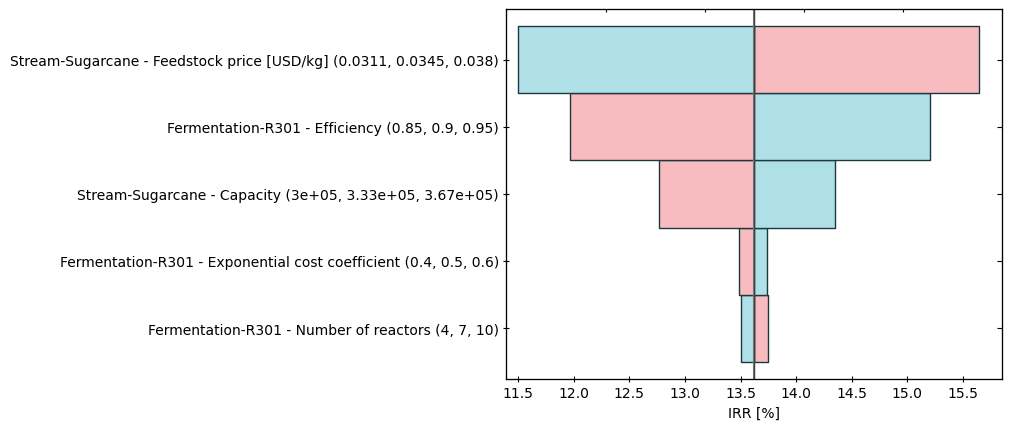

In [27]:
IRR, utility_cost = model.metrics
metric_index = IRR.index
index = [i.describe(distribution=False) # Instead of displaying distribution, it displays lower, baseline, and upper values
         for i in model.parameters] 
bst.plots.plot_single_point_sensitivity(100 * baseline[metric_index],
                                        100 * lower[metric_index], 
                                        100 * upper[metric_index],
                                        name='IRR [%]',
                                        index=index)

Note that blue represents the upper limit while red the lower limit.